<a href="https://colab.research.google.com/github/Mehakcrystal/SOC/blob/main/Deepfake_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Creation

In [7]:
# ------------------ Kaggle Dataset Download (Optional) ------------------
!pip install -q kaggle
!mkdir -p ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json
# Upload kaggle.json manually in Colab: Files > Upload kaggle.json to ~/.kaggle/
!kaggle datasets download -d greatgamedota/faceforensics
!unzip -q faceforensics.zip -d data/FF
!pip install opencv-python

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open faceforensics.zip, faceforensics.zip.zip or faceforensics.zip.ZIP.


In [8]:
# Step 1: Upload kaggle.json
from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Step 2: Move to the right location and fix permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Install kaggle CLI and download the dataset
!pip install -q kaggle
!kaggle datasets download -d manjilkarki/deepfake-and-real-images
!mkdir -p data/df_real_fake
!unzip -q deepfake-and-real-images.zip -d data/df_real_fake

# 3. Confirm folder structure
!find data/df_real_fake -maxdepth 2 -type d

# Optional: Install OpenCV
!pip install opencv-python


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 97% 1.63G/1.68G [00:01<00:00, 1.17GB/s]
100% 1.68G/1.68G [00:01<00:00, 1.16GB/s]
data/df_real_fake
data/df_real_fake/Dataset
data/df_real_fake/Dataset/Validation
data/df_real_fake/Dataset/Train
data/df_real_fake/Dataset/Test


## Code Implementation

In [12]:
# ------------------ Imports ------------------
import io, numpy as np
from PIL import Image
import torch, torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import torchvision.models as models
#import cv2
!pip install opencv-python
import cv2
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# ------------------ Augmentations ------------------
class RandomJPEG:
    def __init__(self, quality=(30, 90), p=0.5):
        self.quality = quality; self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            q = np.random.randint(self.quality[0], self.quality[1])
            buffer = io.BytesIO()
            img.save(buffer, format='JPEG', quality=q)
            img = Image.open(buffer).convert('RGB')
        return img

class AddGaussianNoise:
    def __init__(self, mean=0., std=5., p=0.5):
        self.mean = mean; self.std = std; self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            arr = np.array(img).astype(np.float32)
            noise = np.random.normal(self.mean, self.std, arr.shape)
            arr = np.clip(arr + noise, 0, 255)
            img = Image.fromarray(arr.astype(np.uint8))
        return img

train_transforms = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    RandomJPEG(quality=(30, 90), p=0.7),
    AddGaussianNoise(std=10, p=0.5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
])

val_transforms = T.Compose([
    T.Resize(256), T.CenterCrop(224), T.ToTensor()
])

# ------------------ High-Frequency Transform ------------------
class HighFreqTransform:
    def __call__(self, pil_img):
        arr = np.array(pil_img)
        hf = np.zeros_like(arr)
        for c in range(3):
            channel = cv2.Laplacian(arr[:, :, c], cv2.CV_32F, ksize=3)
            hf[:, :, c] = cv2.convertScaleAbs(channel)
        return Image.fromarray(hf)

hf_transform = HighFreqTransform()

# ------------------ DualStreamEncoder ------------------
class DualStreamEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.rgb_encoder = models.resnet18(weights="IMAGENET1K_V1")
        self.rgb_encoder.fc = nn.Linear(self.rgb_encoder.fc.in_features, embed_dim)

        self.hf_encoder = models.resnet18(weights="IMAGENET1K_V1")
        self.hf_encoder.fc = nn.Linear(self.hf_encoder.fc.in_features, embed_dim)

        self.fc_fuse = nn.Sequential(
            nn.Linear(2 * embed_dim, embed_dim),
            nn.ReLU(),
        )

    def forward(self, x_rgb, x_hf):
        feat_rgb = self.rgb_encoder(x_rgb)
        feat_hf = self.hf_encoder(x_hf)
        feat = torch.cat([feat_rgb, feat_hf], dim=1)
        return self.fc_fuse(feat)

# ------------------ Prototype Loss ------------------
def proto_loss_fn(support_embed, support_labels, query_embed, query_labels):
    all_embed = torch.cat([support_embed, query_embed], dim=0)
    all_labels = torch.cat([support_labels, query_labels], dim=0)

    classes = torch.sort(torch.unique(all_labels))[0]
    prototypes = torch.stack([all_embed[all_labels == c].mean(dim=0) for c in classes])

    query_labels_mapped = torch.zeros_like(query_labels)
    for i, c in enumerate(classes):
        query_labels_mapped[query_labels == c] = i

    dists = torch.cdist(query_embed, prototypes)
    logits = -dists
    return F.cross_entropy(logits, query_labels_mapped), logits, query_labels_mapped



In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score
# Define the to_hf_tensor function outside the loops
def to_hf_tensor(batch, hf_transform, device):
    return torch.stack([
        T.ToTensor()(hf_transform(T.ToPILImage()(img.cpu()))).to(device)
        for img in batch
    ])



def validate_with_prototypes(model, train_loader, val_loader, hf_transform, device):
    model.eval()

    # --- Build prototypes from training embeddings ---
    support_embeds, support_labels = [], []
    with torch.no_grad():
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            hf_imgs = to_hf_tensor(imgs)
            emb = model(imgs, hf_imgs)
            support_embeds.append(emb)
            support_labels.append(labels)
    support_embeds = torch.cat(support_embeds)
    support_labels = torch.cat(support_labels)

    unique_classes = torch.sort(torch.unique(support_labels))[0]
    prototypes = torch.stack([
        support_embeds[support_labels == c].mean(dim=0) for c in unique_classes
    ])

    # --- Embed validation images ---
    query_embeds, query_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            hf_imgs = to_hf_tensor(imgs)
            emb = model(imgs, hf_imgs)
            query_embeds.append(emb)
            query_labels.append(labels)
    query_embeds = torch.cat(query_embeds)
    query_labels = torch.cat(query_labels)

    # --- Predict using nearest prototype ---
    dists = torch.cdist(query_embeds, prototypes)  # shape: [num_val, num_classes]
    pred_indices = dists.argmin(dim=1)

    # --- Map true labels to prototype class indices ---
    mapped_labels = torch.zeros_like(query_labels)
    for i, c in enumerate(unique_classes):
        mapped_labels[query_labels == c] = i

    # --- Accuracy ---
    acc = accuracy_score(mapped_labels.cpu().numpy(), pred_indices.cpu().numpy())

    # --- ROC-AUC (optional) ---
    try:
        probs = (-dists).softmax(dim=1)
        auc = roc_auc_score(mapped_labels.cpu().numpy(), probs[:, 1].cpu().numpy())
    except:
        auc = float('nan')

    print(f"Val Accuracy: {acc:.4f} | ROC-AUC: {auc:.4f}")


In [29]:

# ------------------ Data & Model Init ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.data import Subset
import random

# Load full dataset
full_train_dataset = ImageFolder(root="data/df_real_fake/Dataset/Train", transform=train_transforms)
full_val_dataset = ImageFolder(root="data/df_real_fake/Dataset/Validation", transform=val_transforms)

# Select small subset (e.g., 20 images for train, 20 for val)
train_indices = random.sample(range(len(full_train_dataset)), min(100, len(full_train_dataset)))

val_indices = random.sample(range(len(full_val_dataset)), min(20, len(full_val_dataset)))

# Create subset datasets
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_val_dataset, val_indices)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

model = DualStreamEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------ Training Loop ------------------
num_epochs = 2  # Just for testing
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
support_per_class = 1

for epoch in range(num_epochs):
    model.train()
    total_loss, step_count = 0.0, 0
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        if len(imgs) <= support_per_class * 2:
            print("Skipping small batch.")
            continue

        unique_classes = labels.unique()
        support_idxs, query_idxs = [], []

        for cls in unique_classes:
            cls_idxs = (labels == cls).nonzero(as_tuple=True)[0]
            if len(cls_idxs) < support_per_class + 1:
                continue
            cls_idxs = cls_idxs[torch.randperm(len(cls_idxs))]
            support_idxs += cls_idxs[:support_per_class].tolist()
            query_idxs += cls_idxs[support_per_class:].tolist()

        if len(support_idxs) == 0 or len(query_idxs) == 0:
            print("Skipping batch due to class imbalance.")
            continue

        support_imgs = imgs[support_idxs]
        support_labels = labels[support_idxs]
        query_imgs = imgs[query_idxs]
        query_labels = labels[query_idxs]

        # High-frequency tensors
        '''def to_hf_tensor(batch):
            return torch.stack([
                T.ToTensor()(hf_transform(T.ToPILImage()(img.cpu()))).to(device)
                for img in batch
            ])'''

        # OVERWRITE any previous version
        def to_hf_tensor(batch, hf_transform= hf_transform, device= device):
          import torchvision.transforms as T
          from PIL import Image
          import torch
          return torch.stack([
            T.ToTensor()(hf_transform(T.ToPILImage()(img.cpu()))).to(device)
            for img in batch
            ])


        support_hf = to_hf_tensor(support_imgs, hf_transform, device)
        query_hf = to_hf_tensor(query_imgs, hf_transform, device)

        support_embed = model(support_imgs, support_hf)
        query_embed = model(query_imgs, query_hf)

        loss, logits, q_mapped = proto_loss_fn(support_embed, support_labels, query_embed, query_labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        step_count += 1

    avg_loss = total_loss / step_count if step_count > 0 else 0
    print(f"Train Loss: {avg_loss:.4f}")



Epoch 1/2


100%|██████████| 25/25 [02:18<00:00,  5.53s/it]


Train Loss: 0.0825

Epoch 2/2


100%|██████████| 25/25 [02:13<00:00,  5.32s/it]

Train Loss: 0.0377


In [30]:
validate_with_prototypes(model, train_loader, val_loader, hf_transform, device)

Val Accuracy: 0.3000 | ROC-AUC: 0.7451


In [40]:
# ---- Grad-CAM Function ----
import matplotlib.pyplot as plt
import cv2
import numpy as np

def show_gradcam(model, img_tensor, hf_tensor, device= device, class_idx=None, layer_name="layer4"):
    model.eval()

    activations, gradients = {}, {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_input, grad_output):
        gradients['value'] = grad_output[0]

    # Hook into RGB encoder’s layer4
    target_layer = dict(model.rgb_encoder.named_modules())[layer_name]
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    img_tensor = img_tensor.unsqueeze(0)  # add batch dimension
    hf_tensor = hf_tensor.unsqueeze(0)
    img_tensor, hf_tensor = img_tensor.to(device), hf_tensor.to(device)
    output = model(img_tensor, hf_tensor)
    pred_class = output.argmax(dim=1).item() if class_idx is None else class_idx

    # Backward pass
    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    grads = gradients['value'][0].detach().cpu().numpy()
    acts = activations['value'][0].detach().cpu().numpy()

    weights = np.mean(grads, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * acts, axis=0)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    orig = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    orig = (orig - orig.min()) / (orig.max() - orig.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = heatmap * 0.4 + np.uint8(255 * orig)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(orig)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(np.uint8(overlay))
    plt.axis("off")
    plt.show()

    fwd_handle.remove()
    bwd_handle.remove()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


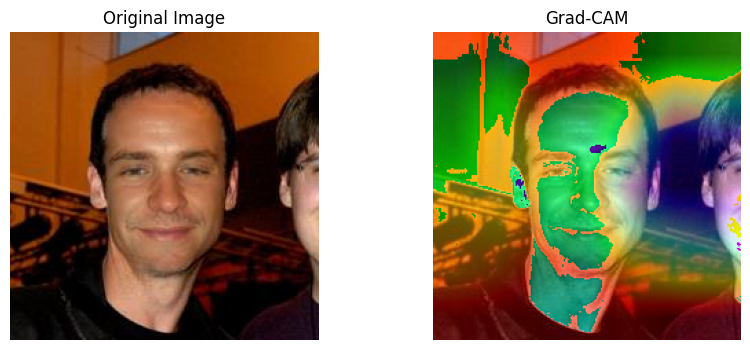

In [32]:
# Get a sample image + its HF version, compatible with your pipeline
sample_img, _ = val_dataset[0]  # from your Subset
hf_img = to_hf_tensor(sample_img.unsqueeze(0), hf_transform, device)[0]

# Visualize Grad-CAM
show_gradcam(model, sample_img, hf_img, device)


In [33]:
from sklearn.manifold import TSNE
import seaborn as sns

def plot_tsne(model, loader, hf_transform, device):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs, lbls = imgs.to(device), lbls.to(device)
            hf_imgs = to_hf_tensor(imgs)
            embs = model(imgs, hf_imgs)
            embeddings.append(embs.cpu())
            labels.append(lbls.cpu())

    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    reduced = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='coolwarm', s=50)
    plt.title("t-SNE of Embeddings (Real vs Fake)")
    plt.legend(title="Class", labels=["Real", "Fake"])
    plt.show()


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


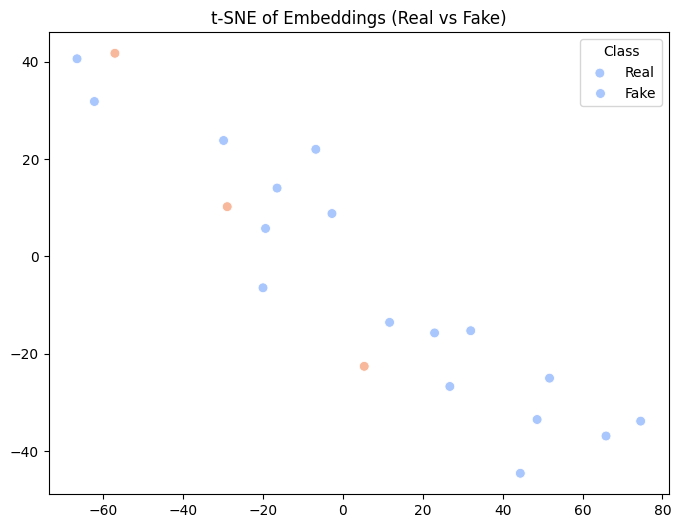

In [34]:
plot_tsne(model, val_loader, hf_transform, device)


In [37]:
!pip install umap-learn

from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap(model, loader, hf_transform, device):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for imgs, lbls in tqdm(loader):
            imgs, lbls = imgs.to(device), lbls.to(device)
            hf_imgs = to_hf_tensor(imgs)  # default args used
            embs = model(imgs, hf_imgs)
            embeddings.append(embs.cpu())
            labels.append(lbls.cpu())

    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()

    # Run UMAP
    umap = UMAP(n_components=2, random_state=42)
    reduced = umap.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='coolwarm', s=50)
    plt.title("UMAP of Embeddings (Real vs Fake)")
    plt.legend(title="Class", labels=["Real", "Fake"])
    plt.grid(True)
    plt.show()




100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


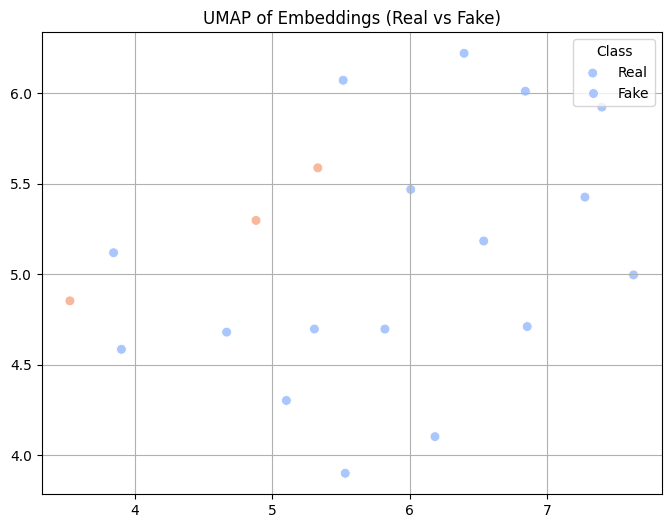

In [38]:
plot_umap(model, val_loader, hf_transform, device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


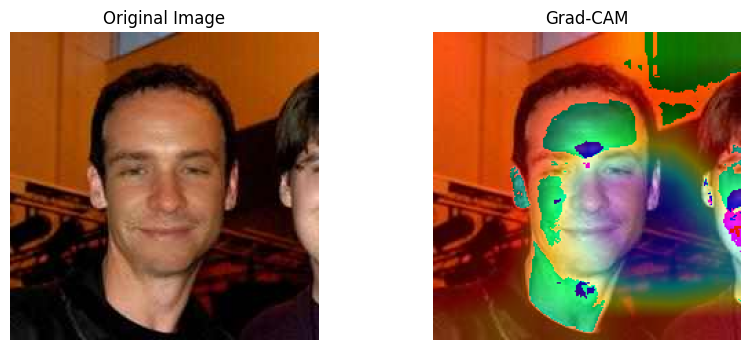

In [41]:
aug_img = RandomJPEG(p=1.0)(T.ToPILImage()(sample_img.cpu()))
aug_tensor = T.ToTensor()(aug_img).to(device)
aug_hf_tensor = to_hf_tensor(aug_tensor.unsqueeze(0))[0]

show_gradcam(model, aug_tensor, aug_hf_tensor)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Load a sample from dataset (e.g., from val_dataset)
orig_img_pil, label = full_val_dataset[0]  # This gives PIL image because transform is applied later

# Apply your train-time augmentations (simulate one augmentation)
augmented_img_tensor = train_transforms(orig_img_pil)
augmented_img_pil = T.ToPILImage()(augmented_img_tensor)

# Show both images side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(orig_img_pil)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_img_pil)
plt.title("Augmented Image")
plt.axis('off')

plt.tight_layout()
plt.show()


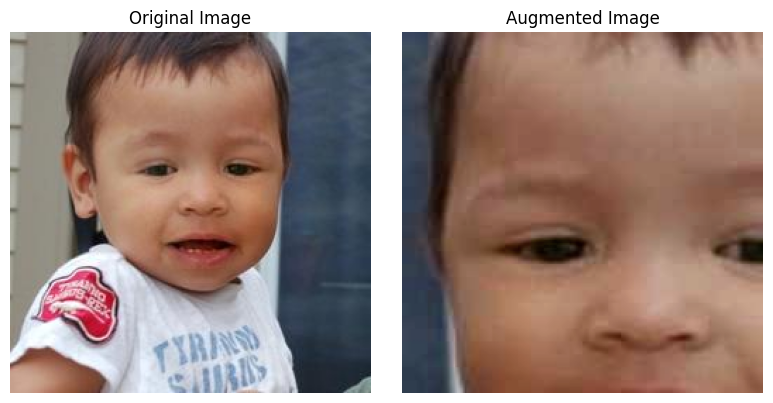

In [43]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Load a sample from dataset (e.g., from val_dataset)
# Load without transform
from PIL import Image
orig_img_path = full_val_dataset.samples[0][0]  # path to image
orig_img_pil = Image.open(orig_img_path).convert('RGB')
 # This gives PIL image because transform is applied later

# Apply your train-time augmentations (simulate one augmentation)
augmented_img_tensor = train_transforms(orig_img_pil)
augmented_img_pil = T.ToPILImage()(augmented_img_tensor)

# Show both images side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(orig_img_pil)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_img_pil)
plt.title("Augmented Image")
plt.axis('off')

plt.tight_layout()
plt.show()
